In [ ]:
pip install --upgrade gtfs-realtime-bindings


  Preparing metadata (setup.py) ... done
  Created wheel for gtfs-realtime-bindings: filename=gtfs_realtime_bindings-1.0.0-py3-none-any.whl size=5988 sha256=a9f73ab60dfc1d4fe30f65fef308b6a020fafa85ceb389fff7c41e3a0a80e98a
  Stored in directory: /root/.cache/pip/wheels/43/98/27/68e4d1de8bb9d8505cfe412bf9af51e66f3e3bd2c98c849c3f
Successfully built gtfs-realtime-bindings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.transit import gtfs_realtime_pb2
import requests
import time
from datetime import datetime, timezone, timedelta
import os
import pandas as pd
import numpy as np
#from protobuf_to_dict import protobuf_to_dict
import sqlite3
import csv
import matplotlib.pyplot as plt
#Following 2 lines added for Google Colab
base_dir = '/content/drive/My Drive/Real_Time_LIRR/'
os.chdir(base_dir)

def db_setup():
    con = sqlite3.connect("lirr_gtfs.db")
    cur = con.cursor()

    # Drop tables
    cur.execute('DROP TABLE IF EXISTS agency')
    cur.execute('DROP TABLE IF EXISTS calendar_dates')
    cur.execute('DROP TABLE IF EXISTS feed_info')
    cur.execute('DROP TABLE IF EXISTS routes')
    cur.execute('DROP TABLE IF EXISTS shapes')
    cur.execute('DROP TABLE IF EXISTS stop_times')
    cur.execute('DROP TABLE IF EXISTS stops')
    cur.execute('DROP TABLE IF EXISTS transfers')
    cur.execute('DROP TABLE IF EXISTS trips')
    #crete table
    cur.execute('''CREATE TABLE IF NOT EXISTS agency (
                        agency_id TEXT PRIMARY KEY,
                        agency_name TEXT,
                        agency_url TEXT,
                        agency_timezone TEXT,
                        agency_lang TEXT,
                        agency_phone TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS calendar_dates (
                        service_id TEXT,
                        date TEXT,
                        exception_type INTEGER,
                        PRIMARY KEY (service_id, date))''')

    cur.execute('''CREATE TABLE IF NOT EXISTS feed_info (
                        feed_publisher_name TEXT,
                        feed_publisher_url TEXT,
                        feed_timezone TEXT,
                        feed_lang TEXT,
                        feed_version TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS routes (
                        route_id TEXT PRIMARY KEY,
                        route_long_name TEXT,
                        route_type INTEGER,
                        route_color TEXT,
                        route_text_color TEXT)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS shapes (
                        shape_id TEXT,
                        shape_pt_lat REAL,
                        shape_pt_lon REAL,
                        shape_pt_sequence INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS stop_times (
                        trip_id TEXT,
                        arrival_time TEXT,
                        departure_time TEXT,
                        stop_id TEXT,
                        stop_sequence INTEGER,
                        pickup_type INTEGER,
                        drop_off_type INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS stops (
                        stop_id TEXT PRIMARY KEY,
                        stop_code TEXT,
                        stop_name TEXT,
                        stop_lat REAL,
                        stop_lon REAL,
                        stop_url TEXT,
                        wheelchair_boarding INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS transfers (
                        from_stop_id TEXT,
                        to_stop_id TEXT,
                        from_trip_id TEXT,
                        to_trip_id TEXT,
                        transfer_type INTEGER,
                        min_transfer_time INTEGER)''')

    cur.execute('''CREATE TABLE IF NOT EXISTS trips (
                        route_id TEXT,
                        service_id TEXT,
                        trip_id TEXT PRIMARY KEY,
                        trip_headsign TEXT,
                        trip_short_name TEXT,
                        direction_id INTEGER,
                        shape_id TEXT,
                        peak_offpeak INTEGER)''')

    file_list = {
        'agency': 'google_transit/agency.txt',
        'calendar_dates': 'google_transit/calendar_dates.txt',
        'feed_info': 'google_transit/feed_info.txt',
        'routes': 'google_transit/routes.txt',
        'shapes': 'google_transit/shapes.txt',
        'stop_times': 'google_transit/stop_times.txt',
        'stops': 'google_transit/stops.txt',
        'transfers': 'google_transit/transfers.txt',
        'trips': 'google_transit/trips.txt'
    }


    for table_name, file_path in file_list.items():
        with open(file_path, 'r') as file:
            reader = csv.reader(file, delimiter=',')
            headers = next(reader)
            placeholders = ','.join(['?'] * len(headers))
            query = f'INSERT OR IGNORE INTO {table_name} ({",".join(headers)}) VALUES ({placeholders})'
            for row in reader:
                try:
                    cur.execute(query, row)
                except sqlite3.IntegrityError as e:
                    print(f"Error inserting row into {table_name}: {row}")
                    print(e)

    con.commit()
    con.close()

def import_txt_as_list(path):
    lists = {}
    for file_name in os.listdir(path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(path, file_name)
            with open(file_path, 'r') as file:
                lists[file_name] = [line.strip() for line in file]
    return lists
csv_path_const = '/content/drive/My Drive/Real_Time_LIRR/data/' #With google drive
#csv_path_const = 'data/gtfs_data_collection.csv' #original

Mounted at /content/drive


In [ ]:
def analyze():
    return 0


def print_all_tables():
    con = sqlite3.connect("lirr_gtfs.db")
    cur = con.cursor()
    tables = ['agency', 'calendar_dates', 'feed_info', 'routes', 'shapes', 'stop_times', 'stops', 'transfers', 'trips']

    for table in tables:
        cur.execute(f'SELECT * FROM {table}')
        rows = cur.fetchall()
        print(f'Table: {table}')
        for row in rows:
            print(row)
        print('\n')

    con.close()

In [ ]:
def get_info_trip(cur, train):
    trip_id = train['trip_id']
    trip = cur.execute(f'SELECT * FROM trips WHERE trip_id = ?', (trip_id,)).fetchone()
    route = trip[0]
    service_id = trip[1]
    trip_id = trip[2]
    trip_headsign = trip[3]
    trip_short_name = trip[4]
    direction_id = trip[5]
    shape_id = trip[6] #not used
    peak_offpeak = trip[7]
    terminal_info = [route, service_id, trip_headsign, trip_short_name, direction_id, peak_offpeak]
    return terminal_info


#given a file path, combine every file inside the list into a single pandas dataframe
def combine_all_csv(file_path):

    #list all the files from the directory
    file_list = os.listdir(file_path)
    #print(file_list)
    combined_list = []
    for file in file_list:
        file_str = file_path + '/' + file
        csv_data = read_csv(file_str)

        combined_list.append(csv_data)
        #df = pd.read_csv(file_str)
        #df_combined = df_combined.append(df, ignore_index=True)
    #file_list
    #df_combined = pd.DataFrame(combined_list)
    df_combined = pd.concat([pd.DataFrame(lst) for lst in combined_list], ignore_index=True) #Concatenate the list of DataFrames into a single DataFrame
    return df_combined


#probably redundant
def read_csv(csv_path):
    data = []
    with open(csv_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

def find_train_csv(panda_df, train_id):
    train_data = panda_df[panda_df['train_id'] == train_id]
    #if failed
    if(train_data.empty):
        return None
    return train_data

def find_arrival_time(train_data):
    return train_data['local_arrival_time']

def convert_to_seconds(delay_str):
    parts = delay_str.split()
    minutes = int(parts[0]) if parts[1] == 'm' else 0
    seconds = int(parts[2]) if parts[3] == 's' else 0
    total_seconds = minutes * 60 + seconds
    return total_seconds if delay_str[0] != '-' else -total_seconds

#Given a delay string, convert it to a number representing seconds
def parse_delay(delay):

    sign = 1
    if delay.startswith('-'):
        sign = -1
        delay = delay[1:]

    parts = delay.split(' ')
    minutes = int(parts[0].replace('m', ''))
    seconds = int(parts[1].replace('s', ''))
    total_seconds = minutes * 60 + seconds
    if(sign == -1):
        total_seconds = total_seconds * -1
    return total_seconds


#Given OPTION = -1, remove delays <-15 min or >15 min (Excessive delays)
def clean_data_drop_outliers(data_frame, option):
    data_frame_new = data_frame.copy()
    # Remove duplicate rows this does not work
    #data_frame_new = data_frame_new.drop_duplicates()

    # If option is -1, remove rows with excessive delays
    if option == -1:
        indices_to_drop = []
        for index, row in data_frame_new.iterrows():
            delay_converted_s = parse_delay(row['delay_formatted'])
            if delay_converted_s > (15 * 60) or delay_converted_s < (-15 * 60):
                indices_to_drop.append(index)

        data_frame_new = data_frame_new.drop(indices_to_drop)


    data_frame_new['delay_formatted'] = data_frame_new['delay_formatted'].apply(parse_delay)
    return data_frame_new

#return number of trains aka length of dataframe
def count_trains(pandas_df):
    return len(pandas_df)

#counts the number of trains on a particular route
#Routes/Branches: Babylon, Hempstead, Oyster Bay, Ronkonkoma, Montauk, Long Beach, Far Rockaway, West Hempstead, Port Washington, Port Jefferson, Belmont Park, City Terminal
def count_routes(pandas_df):
    route_counter =  [0,0,0,0,0,0,0,0,0,0,0,0]
    for index, train in pandas_df.iterrows():
        route_id = train['route_id']

        route_counter[int(route_id)-1] = route_counter[int(route_id)-1] + 1

    return route_counter

#count number of trains on each route that arrive 0 min or later
def delayed_trains_per_route(pandas_df):
    route_counter =  [0,0,0,0,0,0,0,0,0,0,0,0]
    for index, train in pandas_df.iterrows():
        route_id = train['route_id']
        #delay = train['delay_formatted']
        delay_seconds = train['delay_formatted']
        #delay_formatted = delay.time()
        #delay_seconds = parse_delay(delay_formatted)
        if(delay_seconds>0):

          route_id = train['route_id']
          route_counter[int(route_id)-1] = route_counter[int(route_id)-1] + 1
    return route_counter

#categorize the severity of delays that happen (negative delay = on time)
def category_of_delays(pandas_df):
    categories = [-float('inf'), -600, -300, -120, 0, 120, 300, 600, float('inf')]
    labels = ['> -10 min', '(-10 to -5 min]', '(-5 to -2 min]', '(-2-0 min]', '(0-2 min]', '(2-5 min]', '(5-10 min]', '>10+ min']
    count_df = pandas_df.copy()

    count_df['category'] = pd.cut(count_df['delay_formatted'], bins=categories, labels=labels)
    category_counts = count_df['category'].value_counts().reindex(labels, fill_value=0)
    #print(category_counts)
    return count_df,category_counts
#sorts delayed trains per hour
def delayed_trains_per_hour(pandas_df):
    count_df = pandas_df.copy()

    count_df['hour'] = pd.to_datetime(count_df['local_arrival_time']).dt.strftime('%H')

    sorted_delays = count_df.groupby('hour').size().reset_index(name='delayed_trains_count')

    return sorted_delays




In [53]:
#Get all transfers of a particualr trip at station station_id
def get_transfers_trip(cur, station_id, trip_id):
    #transfers = cur.execute(f'SELECT ALL FROM transfers WHERE from_stop_id = ?',(station_id)).fechall()
    query = '''
    SELECT *
    FROM transfers
    WHERE from_stop_id = ?
    AND (from_trip_id = ? OR to_trip_id = ?)
    '''
    cur.execute(query, (station_id, trip_id, trip_id))
    transfers = cur.fetchall()
    return transfers

def convert_to_seconds (time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    # Calculate the total number of seconds
    seconds = hours * 3600 + minutes * 60 + seconds

    return seconds
#Method to find how many transfers were "missed". This assumes a 3 min buffer period for all transfers.
#Trains with <3 min buffer period
#Obtains all transfer times via analyzing stop_times.txt
#Returns number of transfers where transfer time is in the negatives


def analyze_transfers_trip_act(cur, transfers, station_id, expected_val, df):
    missed_transfers = 0
    unknown_transfers = 0

    # Iterate through the transfers
    for transfer in transfers:
        from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_id, _ = transfer

        # Find arrival time for both from_trip_id and to_trip_id from df
        transfer_found = False
        transfer_time = None

        # We need to check both from_trip_id and to_trip_id based on expected_val
        if expected_val == 1:  # Arrival comparison
            # Check if from_trip_id exists in the DataFrame
            transfer_row_from = df[df['trip_id'] == from_trip_id]
            if not transfer_row_from.empty:
                transfer_found = True
                transfer_time = pd.to_datetime(transfer_row_from['local_arrival_time'].iloc[0])
        else:  # Departure comparison (assumed to be same as arrival for lack of departure time)
            # Check if to_trip_id exists in the DataFrame
            transfer_row_to = df[df['trip_id'] == to_trip_id]
            if not transfer_row_to.empty:
                transfer_found = True
                transfer_time = pd.to_datetime(transfer_row_to['local_arrival_time'].iloc[0])

        if not transfer_found:
            unknown_transfers += 1
            continue

        # Query stop_times table for arrival times for both from_trip_id and to_trip_id
        query = '''
        SELECT arrival_time, departure_time
        FROM stop_times
        WHERE trip_id = ? AND stop_id = ?
        '''

        # First, check for the from_trip_id (for arrival comparison)
        cur.execute(query, (from_trip_id, station_id))
        stop_times_from = cur.fetchall()

        # Then, check for the to_trip_id (for arrival comparison)
        cur.execute(query, (to_trip_id, station_id))
        stop_times_to = cur.fetchall()

        # If no matching stop times for both directions, it's an unknown transfer
        if not stop_times_from and not stop_times_to:
            unknown_transfers += 1
            continue

        # Extract arrival times for both directions (from_trip_id and to_trip_id)
        transfer_time = transfer_time.tz_localize(None)  # Make naive for comparison
        buffer = timedelta(minutes=3)  # Define the buffer period

        missed_in_from = missed_in_to = False

        # Check missed transfer for from_trip_id
        if stop_times_from:
            arrival_time_str, _ = stop_times_from[0]
            arrival_time_from = pd.to_datetime(arrival_time_str).tz_localize(None)
            if expected_val == 1 and transfer_time - arrival_time_from < buffer:
                missed_in_from = True
            elif expected_val != 1 and transfer_time - arrival_time_from < buffer:
                missed_in_from = True

        # Check missed transfer for to_trip_id
        if stop_times_to:
            arrival_time_str, _ = stop_times_to[0]
            arrival_time_to = pd.to_datetime(arrival_time_str).tz_localize(None)
            if expected_val == 1 and transfer_time - arrival_time_to < buffer:
                missed_in_to = True
            elif expected_val != 1 and transfer_time - arrival_time_to < buffer:
                missed_in_to = True

        # If the transfer is missed in either direction, increment missed transfers
        if missed_in_from or missed_in_to:
            missed_transfers += 1

    return missed_transfers, unknown_transfers


In [58]:


def time_to_seconds(t):
    """Convert a time object to the number of seconds since midnight."""
    return t.hour * 3600 + t.minute * 60 + t.second

def analyze_transfers_trip(cur, station_id, df):
    missed_transfer_count = 0

    # Iterate through each train in the DataFrame
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        arrival_time_str = row['local_arrival_time']

        # Strip out the timezone part for comparison purposes
        arrival_time_str = arrival_time_str[:19]  # Keep the first 19 characters (YYYY-MM-DD HH:MM:SS)
        arrival_time = datetime.strptime(arrival_time_str, "%Y-%m-%d %H:%M:%S").time()  # Convert to time object

        # Fetch all transfers related to the trip_id (either as from_trip_id or to_trip_id)
        cur.execute('''
            SELECT from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_type, min_transfer_time
            FROM transfers
            WHERE (from_trip_id = ? OR to_trip_id = ?)
            AND (from_stop_id = ? OR to_stop_id = ?)
        ''', (trip_id, trip_id, station_id, station_id))

        transfers = cur.fetchall()

        # For each transfer, we need to check the other trip's departure time
        for transfer in transfers:
            # Extract data from transfer tuple
            from_stop_id, to_stop_id, from_trip_id, to_trip_id, transfer_type, min_transfer_time = transfer

            # Determine paired trip based on the current trip's direction
            if trip_id == from_trip_id:
                paired_trip_id = to_trip_id
            elif trip_id == to_trip_id:
                paired_trip_id = from_trip_id
            else:
                continue  # If the current trip doesn't match either from or to, skip this transfer

            # Fetch the stop_time for the paired trip_id
            cur.execute('''
                SELECT departure_time
                FROM stop_times
                WHERE trip_id = ? AND stop_id = ?
                ORDER BY stop_sequence
                LIMIT 1
            ''', (paired_trip_id, station_id))

            paired_departure_time_row = cur.fetchone()

            if paired_departure_time_row:
                # Extract the departure time and convert to a time object
                paired_departure_time_str = paired_departure_time_row[0]
                paired_departure_time = datetime.strptime(paired_departure_time_str, "%H:%M:%S").time()

                # Convert both times to seconds since midnight
                arrival_seconds = time_to_seconds(arrival_time)
                paired_departure_seconds = time_to_seconds(paired_departure_time)

                # Check if the departure time is before or equal to arrival time, or within 3 minutes
                if (paired_departure_seconds <= arrival_seconds) or (abs(paired_departure_seconds - arrival_seconds) <= 180):
                    missed_transfer_count += 1

    return missed_transfer_count



In [ ]:
def count_delayed_trains_info(pandas_df):

    count_df = pandas_df.copy()

    for idx, row in count_df.iterrows():
        trip_id = row['trip_id']
        query = """
            SELECT peak_offpeak
            FROM trips
            WHERE trip_id = ?
        """
        result = cur.execute(query, (trip_id,)).fetchone()

        if result:
            count_df.at[idx, 'peak_offpeak'] = result[0]
        else:
            count_df.at[idx, 'peak_offpeak'] = 3
    am_peak_count = count_df[(count_df['direction_id'].astype(int) == 1) & (count_df['peak_offpeak'].astype(int) == 1)].shape[0]
    pm_peak_count = count_df[(count_df['direction_id'].astype(int) == 0) & (count_df['peak_offpeak'].astype(int) == 1)].shape[0]

    peak_count = count_df[count_df['peak_offpeak'].astype(int) == 1].shape[0]
    off_peak_count = count_df[count_df['peak_offpeak'].astype(int) == 0].shape[0]
    unknown_count = count_df[count_df['peak_offpeak'].astype(int) == 3].shape[0]
    print(f"AM Peak count: {am_peak_count}")
    print(f"PM Peak count: {pm_peak_count}")
    print(f"Peak count: {peak_count}")
    print(f"Off Peak count: {off_peak_count}")
    print(f"Unknown count: {unknown_count}")
    print(f"Total count: {len(pandas_df)}")
    result = {
        'AM Peak': am_peak_count,
        'PM Peak': pm_peak_count,
        'Peak': peak_count,
        'Off Peak': off_peak_count,
        'Unknown': unknown_count
    }
    return count_df, result


In [ ]:
def count_delayed_trains_info_n(pandas_df, res):
    #GIVEN modified dataframe with peak_offpeak

    count_df = pandas_df.copy()


    delayed_trains_count = len(count_df[count_df['delay_formatted'].astype(int) > 0])
    print(f"Total delayed trains: {delayed_trains_count}")

    # Filter out delayed trains only
    delayed_trains_info = count_df[count_df['delay_formatted'] > 0]

    # Calculate the average delay time for delayed trains
    avg_delay = delayed_trains_info['delay_formatted'].mean()/60
    print(f"Average delay time (minutes): {avg_delay:.2f}")

    am_peak_count = delayed_trains_info[(delayed_trains_info['direction_id'].astype(int) == 1) & (delayed_trains_info['peak_offpeak'].astype(int) == 1)].shape[0]
    pm_peak_count = delayed_trains_info[(delayed_trains_info['direction_id'].astype(int) == 0) & (delayed_trains_info['peak_offpeak'].astype(int) == 1)].shape[0]
    peak_count =delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 1].shape[0]
    off_peak_count = delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 0].shape[0]
    unknown_count = delayed_trains_info[delayed_trains_info['peak_offpeak'].astype(int) == 3].shape[0]
    print("Number of Late trains: ")
    print(f"AM Peak count: {am_peak_count}")
    print(f"PM Peak count: {pm_peak_count}")
    print(f"Peak count: {peak_count}")
    print(f"Off Peak count: {off_peak_count}")
    print(f"Unknown count: {unknown_count}")
    print(f"Total count: {len(pandas_df)}")
    print("")
    print("Percentage of trains Late: ")
    am_peak_percentage = (am_peak_count / res['AM Peak'])*100
    pm_peak_percentage = (pm_peak_count / res['PM Peak'])*100
    peak_percentage = (peak_count / res['Peak'])*100
    off_peak_percentage = (off_peak_count / res['Off Peak'])*100
    unknown_percentage = (unknown_count / res['Unknown'])*100
    print(f"AM Peak percentage: {am_peak_percentage:.2f}%")
    print(f"PM Peak percentage: {pm_peak_percentage:.2f}%")
    print(f"Peak percentage: {peak_percentage:.2f}%")
    print(f"Off Peak percentage: {off_peak_percentage:.2f}%")
    print(f"Unknown percentage: {unknown_percentage:.2f}%")


this sets up the SQL tables that are needed for data analysis


The data is cleaned by removing excessive (>15 min late or >15 min early) delays. Trains which exceed this time period often are either nonrevenue moves, or a result of a massive service disruption (suspension, cancelled train, police activity, mechanical problems, etc.)

In [ ]:
db_setup()

#print_all_tables()
#csv_path_const_1 = 'data/gtfs_data_collection1.csv'
#csv_data = read_csv(csv_path_const_1)
#print(csv_data)
#first_data = csv_data[0]
#print(first_data)

con = sqlite3.connect("lirr_gtfs.db")
cur = con.cursor()
#ti = get_info_trip(cur, first_data)
#print(ti)
print(csv_path_const)
combined_df = combine_all_csv(csv_path_const)

#print(combined_df)
cleaned_data = clean_data_drop_outliers(combined_df,-1)
print(cleaned_data)




/content/drive/My Drive/Real_Time_LIRR/data/
              trip_id direction  delay_formatted         local_arrival_time  \
1       GO301_24_1618                         20  2024-07-18 10:59:20-04:00   
2       GO301_24_2018                       -103  2024-07-18 10:23:43-04:00   
3       GO301_24_1294                        -83  2024-07-18 11:27:23-04:00   
4       GO301_24_2722                       -115  2024-07-18 10:44:55-04:00   
5        GO301_24_722                        120  2024-07-18 11:11:00-04:00   
...               ...       ...              ...                        ...   
6946  GO301_24_7953_4                       -218  2024-07-13 14:15:38-04:00   
6947    GO301_24_6253                         93  2024-07-13 14:16:33-04:00   
6948    GO301_24_8888                       -147  2024-07-13 14:20:27-04:00   
6949    GO301_24_8054                         80  2024-07-13 14:22:20-04:00   
6950  GO301_24_6005_3                        643  2024-07-13 14:27:43-04:00   

     s

Counts the total # of trains in the datasest

In [ ]:
count_trains(cleaned_data)

6921

Counts the number of trains that operate each route

Counts the number of delayed trains per route

In [77]:
route_array = (count_routes(cleaned_data))

print("Trains per route")
for index, elem in enumerate(route_array):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()

  print(route_name[0][0] + ": " + str(elem))
print ("------------------------------------------------------")
delayed_route_array = delayed_trains_per_route(cleaned_data)
delay_array = delayed_route_array.copy()
print("Delayed trains per route")
for index, elem in enumerate(delayed_route_array):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()

  print(route_name[0][0] + ": " + str(elem))

Trains per route
Babylon Branch: 1583
Hempstead Branch: 548
Oyster Bay Branch: 175
Ronkonkoma Branch: 1079
Montauk Branch: 164
Long Beach Branch: 603
Far Rockaway Branch: 587
West Hempstead Branch: 455
Port Washington Branch: 0
Port Jefferson Branch: 1142
Belmont Park: 0
City Terminal Zone: 585
------------------------------------------------------
Delayed trains per route
Babylon Branch: 799
Hempstead Branch: 279
Oyster Bay Branch: 99
Ronkonkoma Branch: 554
Montauk Branch: 92
Long Beach Branch: 301
Far Rockaway Branch: 229
West Hempstead Branch: 190
Port Washington Branch: 0
Port Jefferson Branch: 634
Belmont Park: 0
City Terminal Zone: 261


Counts Proportion of delayed trains per route

In [ ]:
for index, (elem1, elem2) in enumerate(zip(route_array,delay_array)):
  route_num = index+1

  query = """
        SELECT route_long_name
        FROM routes
        WHERE route_id = ?
    """

  cur.execute(query,(route_num,))
  route_name = cur.fetchall()
  if(elem1 != 0):
    print(route_name[0][0] + ": " + str(elem2/elem1))
  else:
    print(route_name[0][0] + ": " + str(0))


Babylon Branch: 0.5047378395451674
Hempstead Branch: 0.5091240875912408
Oyster Bay Branch: 0.5657142857142857
Ronkonkoma Branch: 0.5134383688600556
Montauk Branch: 0.5609756097560976
Long Beach Branch: 0.49917081260364843
Far Rockaway Branch: 0.3901192504258944
West Hempstead Branch: 0.4175824175824176
Port Washington Branch: 0
Port Jefferson Branch: 0.5551663747810858
Belmont Park: 0
City Terminal Zone: 0.4461538461538462


Plots the proportion of delays on each route. Not surprisingly, the diesel routes had higher rates of delays due to the inefficiency of diesel traction and the poor reliability of the diesel fleet. There are no delays on the Port Washington Branch and Belmont Park branches because the Port Washington Branch does not run through Jamaica, and the Belmont Park Branch is officially discontinued due to the closure of Belmont Park station.

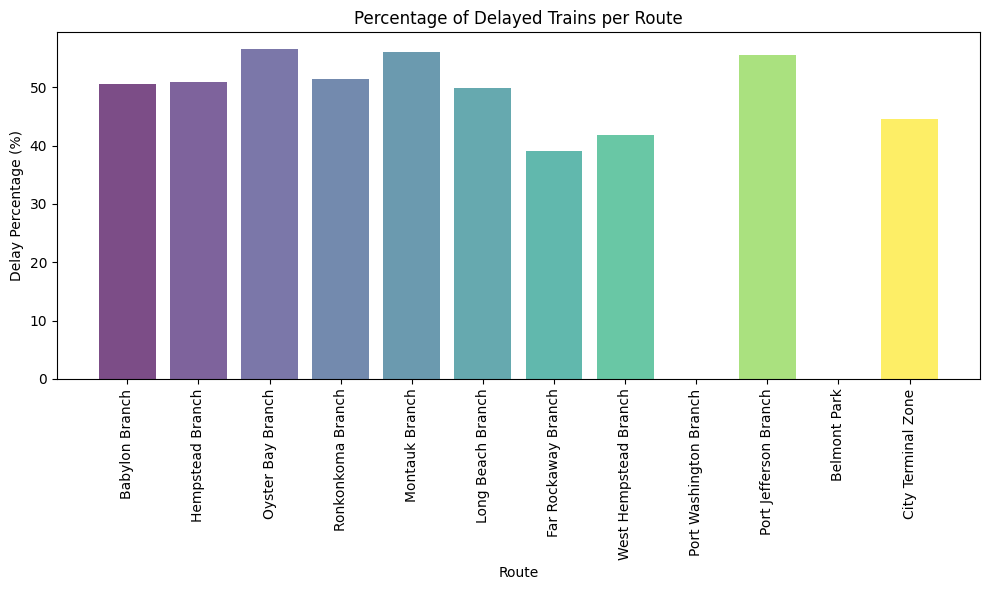

In [81]:
import matplotlib.pyplot as plt

route_names = []
train_counts = []
delayed_train_counts = []
delay_percentages = []

for index, elem in enumerate(route_array):
    route_num = index + 1
    route_name = cur.execute("SELECT route_long_name FROM routes WHERE route_id = ?", (route_num,)).fetchone()[0]
    route_names.append(route_name)
    train_counts.append(elem)

for index, elem in enumerate(delayed_route_array):
    route_num = index + 1
    route_name = cur.execute("SELECT route_long_name FROM routes WHERE route_id = ?", (route_num,)).fetchone()[0]
    delayed_train_counts.append(elem)


for train_count, delayed_train_count in zip(train_counts, delayed_train_counts):
    if train_count != 0:
        delay_percentages.append(delayed_train_count / train_count * 100)
    else:
        delay_percentages.append(0)



num_bars = len(route_names)
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))
plt.figure(figsize=(10, 6))
bars = plt.bar(route_names, delay_percentages, color=colors, alpha=0.7, label='Delay Percentage')
plt.xlabel('Route')
plt.ylabel('Delay Percentage (%)')
plt.title('Percentage of Delayed Trains per Route')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



Counts the number of Westbound (Towards NYC) and Eastbound (Towards Long Island) Trains.

In [71]:
westbound_count = cleaned_data[cleaned_data['direction_id'].astype(int) == 1].shape[0]


eastbound_count = cleaned_data[cleaned_data['direction_id'].astype(int) == 0].shape[0]


print(f"Number of trains Westbound: {westbound_count}")
print(f"Number of trains Eastbound: {eastbound_count}")

Number of trains Westbound: 2832
Number of trains Eastbound: 4089


Counts the number of delayed trains Westbound (Towards NYC) and Eastbound (Towards Long Island) Trains

In [74]:
delayed_trains = cleaned_data[cleaned_data['delay_formatted'] > 0]
westbound_delayed_count =delayed_trains[delayed_trains['direction_id'].astype(int) == 1].shape[0]


eastbound_delayed_count = delayed_trains[delayed_trains['direction_id'].astype(int) == 0].shape[0]


print(f"Number of delayed trains Westbound: {westbound_delayed_count}")
print(f"Number of delayed trains Eastbound: {eastbound_delayed_count}")

westbound_delayed_perc = (westbound_delayed_count/westbound_count)*100
eastbound_delayed_perc = (eastbound_delayed_count/eastbound_count)*100
print(  f"Percentage of delayed trains Westbound: {westbound_delayed_perc:.2f}%")
print(  f"Percentage of delayed trains Eastbound: {eastbound_delayed_perc:.2f}%")



Number of delayed trains Westbound: 1335
Number of delayed trains Eastbound: 2103
Percentage of delayed trains Westbound: 47.14%
Percentage of delayed trains Eastbound: 51.43%


Counts the total number of trains, and number of delayed trains, and percentage of delayed trains (all trains in the dataset). A Delayed train in this case is any train that arrives more than 1 minute after the scheduled time.

In [ ]:

total_trains = cleaned_data.shape[0]
delayed_trains = cleaned_data[cleaned_data['delay_formatted'] > 0].shape[0]
percentage_delayed_trains = (delayed_trains / total_trains) * 100
print(f"Total number of trains: {total_trains}")
print(f"Total number of delayed trains: {delayed_trains}")
print(f"Percentage of delayed trains: {percentage_delayed_trains:.2f}%")

Total number of trains: 6921
Total number of delayed trains: 3438
Percentage of delayed trains: 49.67%


Counts the number of trains delayed per hour

In [ ]:
delayed_trains_hour = delayed_trains_per_hour(cleaned_data)

print(delayed_trains_hour)



   hour  delayed_trains_count
0    00                    17
1    06                    18
2    07                    73
3    08                    94
4    09                   169
5    10                   288
6    11                   355
7    12                   389
8    13                   413
9    14                   462
10   15                   514
11   16                   684
12   17                   836
13   18                   868
14   19                   688
15   20                   448
16   21                   331
17   22                   193
18   23                    81


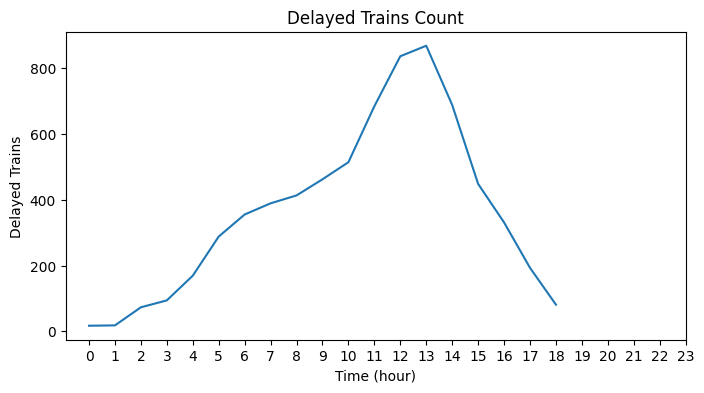

In [ ]:

delayed_trains_hour['delayed_trains_count'].plot(kind='line', figsize=(8, 4), title='Delayed Trains Count')
plt.xticks(range(0, 24))
plt.xlabel('Time (hour)')
plt.ylabel('Delayed Trains')
plt.show()

Categorize the severity of delays

In general, most delays that are not exceptional delays are usually in the 0-2 min timeframe

In [ ]:
#MUST run clean data with option = -1 first
delay_category,category_counts = category_of_delays(cleaned_data)

print(category_counts)

#print(delay_category)

category
> -10 min            21
(-10 to -5 min]     191
(-5 to -2 min]     1808
(-2-0 min]         1463
(0-2 min]          2332
(2-5 min]           939
(5-10 min]          138
>10+ min             29
Name: count, dtype: int64


<ipython-input-18-ad9e1fb82a7e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


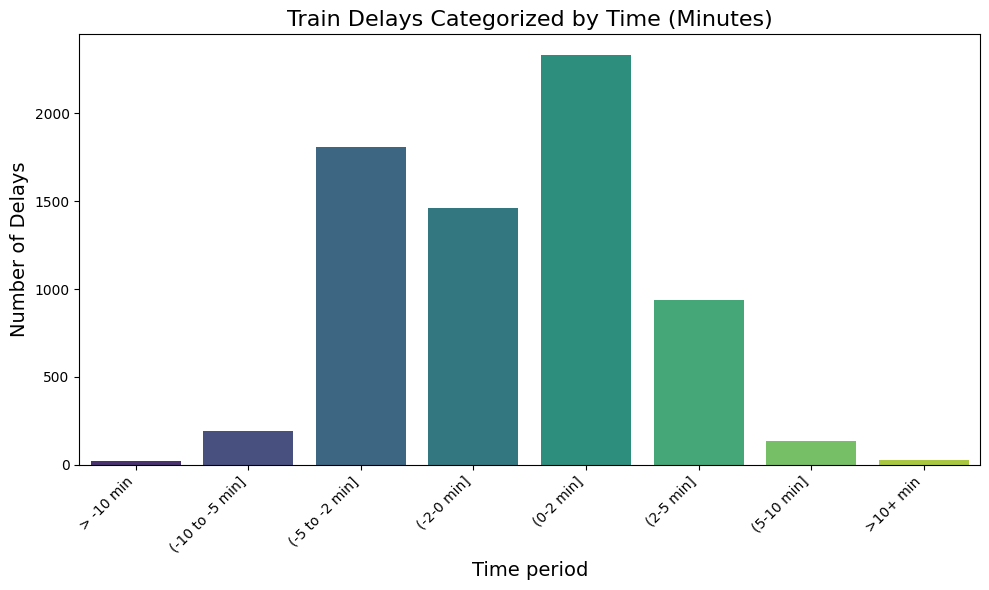

In [ ]:
import seaborn
plt.figure(figsize=(10,6))
seaborn.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

# Customizing the plot
plt.title("Train Delays Categorized by Time (Minutes)", fontsize=16)
plt.xlabel("Time period", fontsize=14)
plt.ylabel("Number of Delays", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
cat_delays = category_of_delays(cleaned_data)

#print(cat_delays)

Prints out the number of Peak, AM Peak, PM Peak, Off Peak, and Unknown (either due to missing gtfs update data or due to non-revenue services) trains in the dataset

In [ ]:
mod_info_df, res = count_delayed_trains_info(cleaned_data)

AM Peak count: 157
PM Peak count: 1645
Peak count: 1802
Off Peak count: 4291
Unknown count: 828
Total count: 6921


In [ ]:
count_delayed_trains_info_n(mod_info_df, res)

Total delayed trains: 3438
Average delay time (minutes): 1.80
Number of Late trains: 
AM Peak count: 95
PM Peak count: 899
Peak count: 994
Off Peak count: 2060
Unknown count: 384
Total count: 6921

Percentage of trains Late: 
AM Peak percentage: 60.51%
PM Peak percentage: 54.65%
Peak percentage: 55.16%
Off Peak percentage: 48.01%
Unknown percentage: 46.38%


Gets the number of transfers possible in the data. The number of transfers is quite low mainly due to missing gtfs data.

In [67]:
station_id = 102 #JAM
transfer_num = 0  # Initialize total transfer counter
transfers_tot = []

for row in cleaned_data.itertuples():
    trip_id = row.trip_id
    local_arrival_time = row.local_arrival_time
    transfers = get_transfers_trip(cur, station_id, trip_id)
    transfer_num += len(transfers)
    #print(len(transfers))
    transfers_tot += transfers

print(f"Total transfers: {transfer_num}")
#print(transfers)

Total transfers: 1297


Gets number of transfers missed due to very late trains. This is very theoretical, as transfer trains can also be late(!). The calculation is that if a train arrives later than the scheduled departure time of the transfer train or less than 3 minutes before the transfer train is scheduled to depart (as some transfers require going up and over an overpass to another platform), then the transfer is missed.

In [62]:
missed_num = analyze_transfers_trip(cur,station_id, cleaned_data)
print(missed_num)

574


Percentage of theoretical missed transfers.

In [64]:
missed_num/transfer_num * 100

44.25597532767926

Closes the connection

In [ ]:
#con.close()